In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

In [26]:
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as poly
import scipy
from scipy import integrate, interpolate, misc
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sys
import os

In [27]:
sys.path.append("/home/chase/codes/python_functions/")
import plotting as my_plot

sys.path.append(os.path.realpath('./pyilt/'))
import ilt

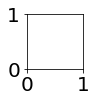

In [28]:
fig, ax = my_plot.instantiate_fig(1, 1)

In [29]:
def get_A_val(q, viscosity=0.890e-3, temp=298):
    # q in nm-1, viscosity in mPa s, temp in K
    return 1.38e-23*temp*q**2*1e27/(6*np.pi*viscosity) # nm/s

def get_gamma_from_radius(radius, q, viscosity=0.890e-3, temp=298):
    return get_A_val(q)/radius # s-1

def get_radius_from_gamma(gamma, q, viscosity=0.890e-3, temp=298):
    return get_A_val(q)/gamma # nm

class data_file():
    def __init__(self, file):
        self.file = file
        self.name = self.file[self.file.rfind('/')+1:self.file.rfind('.')]
        self.read_data()
        self.get_g1()
        return        
        
    def read_data(self):
        with open(self.file) as f:
            self.lines = f.readlines()
            
        self.angle = float(self.lines[3].split()[-1])
        self.n = 1.33 # refractive index
        self.wavelength = 660 # wavelength
        self.q = 4*np.pi*self.n/self.wavelength*np.sin(self.angle*np.pi/180/2)
        
        g2_titles_line = self.lines.index('Lag time (s)         g2-1\n')
        cr_titles_line = self.lines.index('Count Rate History (KHz)  CR CHA / CR CHB\n')
        self.g2_minus_one = pd.DataFrame([l.split() for l in self.lines[g2_titles_line+1:cr_titles_line-2]], 
                                         columns=['lag_time_s', 'g2-1'], dtype=float)
        self.count_rate = pd.DataFrame([l.split() for l in self.lines[cr_titles_line+1:]], 
                                       columns=['t_s', 'a_khz', 'b_khz'], dtype=float)
        return
    
    def make_count_rate_plot(self, fig=False, ax=False):
        if not fig and not ax:
            fig, ax = my_plot.instantiate_fig(xlabel='Time [s]', ylabel='Count rate [kHz]')
        ax.plot(self.count_rate.t_s, self.count_rate.a_khz)
        my_plot.set_layout(fig, ax)
        return fig, ax
        
    def make_count_rate_histogram(self, fig=False, ax=False):
        if not fig and not ax:
            fig, ax = my_plot.instantiate_fig(xlabel='Count rate [kHz]', ylabel='Frequency')    
        n = ax.hist(self.count_rate.a_khz, bins=100)
        my_plot.set_layout(fig, ax)
        return fig, ax
    
    def make_g2_plot(self, fig=False, ax=False):
        fig, ax = my_plot.instantiate_fig(ylabel=r'$g^{(2)} (\tau) - 1$', xlabel=r'$\tau$ [s]')
        ax.set_xscale('log')
        ax.plot(self.g2_minus_one.lag_time_s, self.g2_minus_one['g2-1'])
        my_plot.set_layout(fig, ax)
        return fig, ax

    def get_g1(self):
        self.g1 = self.g2_minus_one[(0 < self.g2_minus_one['g2-1']) &\
                                    (self.g2_minus_one['g2-1'] < 1)].copy()
#         self.g1 = self.g2_minus_one[(1e-6 < self.g2_minus_one.lag_time_s) & 
#                                     (self.g2_minus_one.lag_time_s < 1e-2) & 
#                                     (0 < self.g2_minus_one['g2-1'])].copy()

        self.g1.reset_index(inplace=True, drop=True)
        self.g1['g1'] = np.sqrt(self.g1['g2-1']/self.g1.at[0, 'g2-1'])
        return
    
    def fit_g1(self, alpha=1e-6, low_r_bound=1, up_r_bound=800):
        # gamma_vals in s-1, G_gamma in s
        self.alpha = alpha
        bound = np.array([get_gamma_from_radius(up_r_bound, self.q), 
                          get_gamma_from_radius(low_r_bound, self.q)])
        self.gamma_vals, self.G_gamma, self.res_lsq, self.res_reg, self.g1_fit =\
        ilt.ilt(self.g1.lag_time_s, self.g1.g1, bound, len(self.g1)-1, alpha)
        return
    
    def plot_g1_fit(self):
        fig, ax = my_plot.instantiate_fig(ylabel=r'$g^{(1)} (\tau)$', 
                                          xlabel=r'$\tau$ [s]')
        ax.plot(self.g1.lag_time_s, self.g1.g1, label='Exp.')
        ax.plot(self.g1.lag_time_s, self.g1_fit, label='Fit')
        ax.set_xscale('log')
        my_plot.set_layout(fig, ax, legend=True)
        return fig, ax       
    
    def get_rh_dist(self):
        self.rh_vals = get_radius_from_gamma(self.gamma_vals, self.q)
        self.F_rh = get_A_val(self.q)*self.G_gamma/(self.rh_vals**2)
        return

    def make_rh_dist_plot(self, fig=None, ax=None, label=False):
        if fig == None and ax == None:
            fig, ax = my_plot.instantiate_fig(xlabel=r'$R_h$  [nm]',
                                              ylabel=r'$F(R_h)$  [nm$^{-1}$]')
        if label:
            ax.plot(self.rh_vals, self.F_rh, label=label)
        else:
            ax.plot(self.rh_vals, self.F_rh)
        
        ax.set_xscale('log')
        my_plot.set_layout(fig, ax)
        return fig, ax
    
    def make_gamma_dist_plot(self, fig=None, ax=None, label=False):
        if fig == None and ax == None:
            fig, ax = my_plot.instantiate_fig(xlabel=r'$\Gamma$  [kHz]',
                                              ylabel=r'$G(\Gamma)$  [ms]')
        if label:
            ax.plot(self.gamma_vals*1e-3, self.G_gamma*1e3, label=label)
        else:
            ax.plot(self.gamma_vals*1e-3, self.G_gamma*1e3)
        
        ax.set_xscale('log')
        my_plot.set_layout(fig, ax)
        return fig, ax
    
#     def get_optimal_alpha(self):
#         self.alpha_vals = np.logspace(-5, 2, 100)
#         self.gamma_norms = []
#         self.resid_norms = []
#         self.resid_v = []

#         for alpha in self.alpha_vals:
#             self.fit_g1(alpha)
#             self.gamma_norms.append(np.linalg.norm(np.array(self.G_gamma))**2)
#             self.resid_norms.append(np.linalg.norm(np.array(self.res_lsq))**2)
#             self.resid_v.append(np.linalg.norm(np.array(self.res_lsq))**2 +\
#                                 alpha**2 * np.linalg.norm(np.array(self.res_reg))**2)
            
#         spline = interpolate.interp1d(np.log(self.resid_norms), np.log(self.gamma_norms), 
#                                       kind='quadratic', fill_value="extrapolate")
#         self.resid_norm_pts = np.linspace(min(np.log(self.resid_norms)), 
#                                      max(np.log(self.resid_norms)), 1000)
#         self.gamma_norm_pts = spline(self.resid_norm_pts)

#         y_x = misc.derivative(spline, self.resid_norm_pts, 
#                               dx=self.resid_norm_pts[2]-self.resid_norm_pts[0], n=1)
#         y_xx = misc.derivative(spline, self.resid_norm_pts, 
#                               dx=self.resid_norm_pts[2]-self.resid_norm_pts[0], n=2)
#         self.k = y_xx/((1 + y_x**2)**(3/2))

#         self.x_knee = self.resid_norm_pts[np.argmax(self.k)]
#         self.y_knee = spline(self.x_knee)

#         def find_index_of_nearest_xy(y_array, x_array, y_point, x_point):
#             distance = (y_array-y_point)**2 + (x_array-x_point)**2
#             index = np.where(distance==distance.min())
#             return index[0][0]

#         self.index_knee = find_index_of_nearest_xy(np.log(self.gamma_norms), 
#                                                    np.log(self.resid_norms), 
#                                                    self.y_knee, self.x_knee)
        
#         self.alpha_opt = self.alpha_vals[self.index_knee]
#         self.fit_g1(self.alpha_opt)
#         self.get_rh_dist()
#         return
    
#     def draw_L_curve(self):
#         fig, ax = my_plot.instantiate_fig(ylabel=r'$\Vert  x  \Vert^2$',
#                                          xlabel=r'$\Vert  Ax - g \Vert^2$')
#         ax.set_xscale('log')
#         ax.set_yscale('log')
#         ax.scatter(self.resid_norms, self.gamma_norms)
#         ax.plot(np.exp(self.resid_norm_pts), np.exp(self.gamma_norm_pts), 'k--')
#         ax.scatter(np.exp(self.x_knee), np.exp(self.y_knee))
#         ax.scatter(self.resid_norms[self.index_knee], 
#                    self.gamma_norms[self.index_knee], 
#                    s=200, facecolors='none', edgecolors='r')
#         return fig, ax


    def get_optimal_alpha(self):
        self.alpha_vals = np.logspace(-5, 2, 50)
        self.gamma_norms = []
        self.resid_norms = []
        self.resid_v = []

        for alpha in self.alpha_vals:
            self.fit_g1(alpha)
            self.gamma_norms.append(np.linalg.norm(np.array(self.G_gamma)))
            self.resid_norms.append(np.linalg.norm(np.array(self.res_lsq)))
            self.resid_v.append(np.linalg.norm(np.array(self.res_lsq))**2 +\
                                alpha**2 * np.linalg.norm(np.array(self.res_reg))**2)
            
        spline = interpolate.interp1d(self.resid_norms, self.gamma_norms, 
                                      kind='quadratic', fill_value="extrapolate")
        self.resid_norm_pts = np.linspace(min(self.resid_norms), 
                                     max(self.resid_norms), 1000)
        self.gamma_norm_pts = spline(self.resid_norm_pts)

        y_x = misc.derivative(spline, self.resid_norm_pts, 
                              dx=self.resid_norm_pts[2]-self.resid_norm_pts[0], n=1)
        y_xx = misc.derivative(spline, self.resid_norm_pts, 
                              dx=self.resid_norm_pts[2]-self.resid_norm_pts[0], n=2)
        self.k = y_xx/((1 + y_x**2)**(3/2))

        self.x_knee = self.resid_norm_pts[np.argmax(self.k)]
        self.y_knee = spline(self.x_knee)

        def find_index_of_nearest_xy(y_array, x_array, y_point, x_point):
            distance = (y_array-y_point)**2 + (x_array-x_point)**2
            index = np.where(distance==distance.min())
            return index[0][0]

        self.index_knee = find_index_of_nearest_xy(self.gamma_norms, 
                                                   self.resid_norms, 
                                                   self.y_knee, self.x_knee)
        
        self.alpha_opt = self.alpha_vals[self.index_knee]
        self.fit_g1(self.alpha_opt)
        self.get_rh_dist()
        return
    
    def draw_L_curve(self):
        fig, ax = my_plot.instantiate_fig(ylabel=r'$\Vert  x  \Vert$',
                                         xlabel=r'$\Vert  Ax - g \Vert$')
        ax.scatter(self.resid_norms, self.gamma_norms)
        ax.plot(self.resid_norm_pts, self.gamma_norm_pts, 'k--')
        ax.scatter(self.x_knee, self.y_knee)
        ax.scatter(self.resid_norms[self.index_knee], 
                   self.gamma_norms[self.index_knee], 
                   s=200, facecolors='none', edgecolors='r')
        my_plot.set_layout(fig, ax)
        return fig, ax

In [30]:
images_folder = './images_3/'

data_folder = './data_3/'
files = os.listdir(data_folder)
files.sort()
files = [f for f in files if '.dat' in f and 'fit' not in f]
files

[]

In [16]:
data = {}

for f in files:
    data[f] = data_file(f'{data_folder}/{f}')

In [18]:
# Descriptive plots

for f in files:
    fig, ax = data[f].make_count_rate_plot()
    plt.savefig(f'./{images_folder}/{data[f].name}_count_rate.png', 
                dpi=300, bbox_inches='tight')
    
    fig, ax = data[f].make_count_rate_histogram()
    plt.savefig(f'./{images_folder}/{data[f].name}_count_rate_hist.png', 
                dpi=300, bbox_inches='tight')
    
    fig, ax = data[f].make_g2_plot()
    plt.savefig(f'./{images_folder}/{data[f].name}_g2t.png', 
                dpi=300, bbox_inches='tight')
    
    plt.close('all')

In [19]:
for f in files:
    data[f].get_optimal_alpha()

In [20]:
for f in files:
    fig, ax = data[f].draw_L_curve()
    plt.savefig(f'./{images_folder}/{data[f].name}_L_curve.png', 
                dpi=300, bbox_inches='tight')
    
    fig, ax = data[f].plot_g1_fit()
    plt.savefig(f'./{images_folder}/{data[f].name}_g1_fit.png', 
                dpi=300, bbox_inches='tight')

    fig, ax = data[f].make_gamma_dist_plot()
    plt.savefig(f'./{images_folder}/{data[f].name}_G_gamma_dist.png', 
                dpi=300, bbox_inches='tight')
    
    fig, ax = data[f].make_rh_dist_plot()
    plt.savefig(f'./{images_folder}/{data[f].name}_Rh_dist.png', 
                dpi=300, bbox_inches='tight')
                
    plt.close('all')

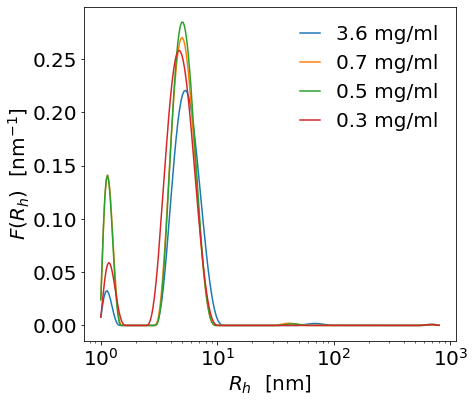

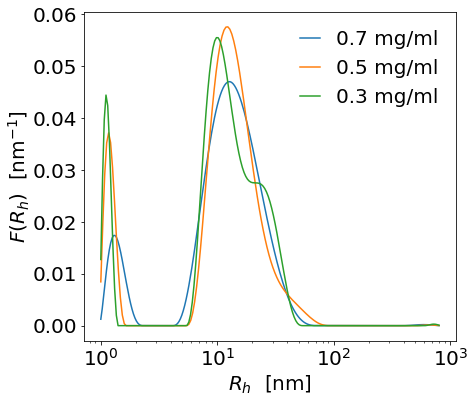

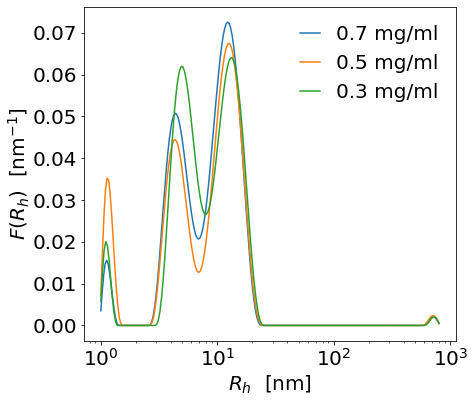

In [895]:
fig, ax = data['mab-3643.dat'].make_rh_dist_plot(label='3.6 mg/ml')
fig, ax = data['mab-0700.dat'].make_rh_dist_plot(fig, ax, label='0.7 mg/ml')
fig, ax = data['mab-0500.dat'].make_rh_dist_plot(fig, ax, label='0.5 mg/ml')
fig, ax = data['mab-0300.dat'].make_rh_dist_plot(fig, ax, label='0.3 mg/ml')

my_plot.set_layout(fig, ax, legend=True)
plt.savefig(f'./images/Rh_dist_mAb_all_c.png', dpi=300, bbox_inches='tight')



for species in ['large', 'small']:    
    fig, ax = data[f'{species}-0700.dat'].make_rh_dist_plot(label='0.7 mg/ml')
    fig, ax = data[f'{species}-0500.dat'].make_rh_dist_plot(fig, ax, label='0.5 mg/ml')
    fig, ax = data[f'{species}-0300.dat'].make_rh_dist_plot(fig, ax, label='0.3 mg/ml')

    my_plot.set_layout(fig, ax, legend=True)
    plt.savefig(f'./images/Rh_dist_{species}_all_c.png', dpi=300, bbox_inches='tight')

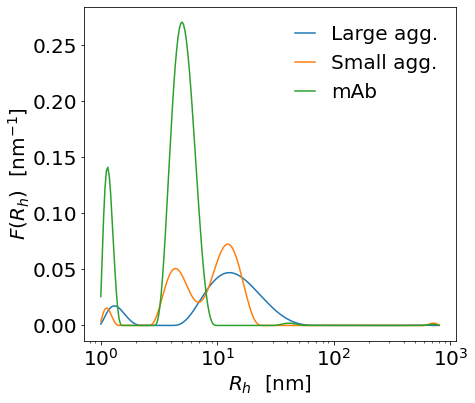

In [12]:
fig, ax = data['large-0700.dat'].make_rh_dist_plot(label='Large agg.')
fig, ax = data['small-0700.dat'].make_rh_dist_plot(fig, ax, label='Small agg.')
fig, ax = data['mab-0700.dat'].make_rh_dist_plot(fig, ax, label='mAb')

my_plot.set_layout(fig, ax, legend=True)
plt.savefig('./images/Rh_dist_species_comparison_700.png', dpi=300, bbox_inches='tight')

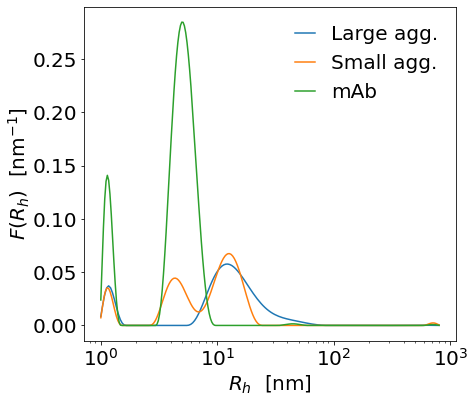

In [13]:
fig, ax = data['large-0500.dat'].make_rh_dist_plot(label='Large agg.')
fig, ax = data['small-0500.dat'].make_rh_dist_plot(fig, ax, label='Small agg.')
fig, ax = data['mab-0500.dat'].make_rh_dist_plot(fig, ax, label='mAb')

my_plot.set_layout(fig, ax, legend=True)
plt.savefig('./images/Rh_dist_species_comparison_500.png', dpi=300, bbox_inches='tight')